In [2]:
#Task 1.1
from __future__ import print_function
from ase import Atoms
from ase.units import eV, Ang, GPa
import Morse

d = 2.5*Ang
a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])
# these parameters are suitable for Cu
# parameters from De Wette et al Physics Letters vol 23 (1966) http://www.sciencedirect.com/science/article/pii/0031916366900138
calc = Morse.MorsePotential(D=0.16156*eV, alpha=2.0926/Ang, r0=2.6163*Ang) 

a.set_calculator(calc) 
a.get_potential_energy()
p = a.get_positions()
p[1,2] = 2.8
a.set_positions(p)
a.get_potential_energy()
f = a.get_forces()
f

array([[ 0.        ,  0.        ,  0.14692478],
       [ 0.        ,  0.        , -0.14692478]])

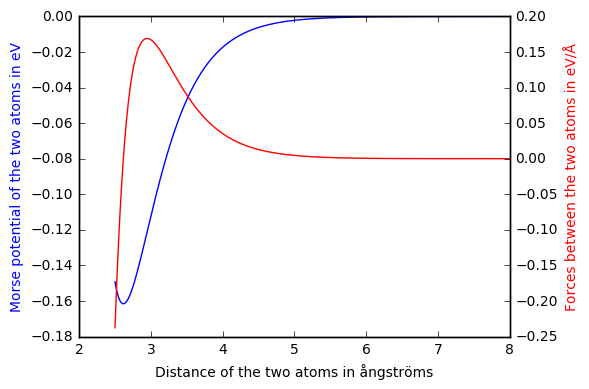

In [3]:
#Deliverable 1.1
from __future__ import print_function
from ase import Atoms
from ase.units import eV, Ang, GPa
import Morse
import matplotlib.pyplot as plt
import numpy as np

#taken from Task 1.1
calc = Morse.MorsePotential(D=0.16156*eV, alpha=2.0926/Ang, r0=2.6163*Ang)
#Array of distances, increasing quadratically, since the force should follow an inverse square law
#the 2.5 - 8 range is typical for lattice constants
dists = np.arange(start = np.sqrt(2.5), stop = np.sqrt(8), step = 0.001)
dists = np.power(dists, 2)

cuPair = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., 0.)]) #The atom pair
cuPair.set_calculator(calc)

forces = [] #the array to record the forces between the atoms
pots = [] #the array to record the Morse potentials
#Computing the forces and potentials:
for distance in dists:
    pos = cuPair.get_positions()
    pos[1,2] = distance
    cuPair.set_positions(pos)
    forces.append(cuPair.get_forces()[0,2])
    pots.append(cuPair.get_potential_energy())
    #print(distance)
    #print(cuPair.get_forces()[1,2])
    
fig, pots_plot = plt.subplots()
pots_plot.set_xlabel('Distance of the two atoms in ångströms')
forces_plot = pots_plot.twinx()
forces_plot.plot(dists, forces, 'r')
pots_plot.plot(dists, pots, 'b')
forces_plot.set_ylabel('Forces between the two atoms in eV/Å', color='r')
pots_plot.set_ylabel('Morse potential of the two atoms in eV', color='b')
fig.tight_layout()
plt.show()

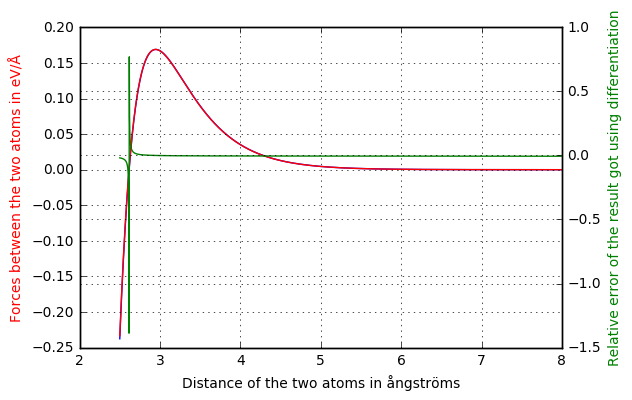

In [139]:
#Task and Deliverable 1.2
#The results of the previous Deliverable are reused

dfs = []
force_diffs = []
for index in range(len(dists)-1):
    dfs.append((pots[index+1]-pots[index])/(dists[index+1]-dists[index]))
    force_diffs.append(dfs[index] - forces[index])

#Plot the results
fig, forceplots = plt.subplots()
forceplots.set_xlabel('Distance of the two atoms in ångströms')
forceplots.plot(dists[:-1], forces[:-1], 'b')
forceplots.plot(dists[:-1], dfs, 'r')
plt.grid()
errplot = forceplots.twinx()
errplot.plot(dists[:-1], np.divide(force_diffs, forces[:-1]), 'g')
plt.grid()
fig.tight_layout()
forceplots.set_ylabel('Forces between the two atoms in eV/Å', color='r')
errplot.set_ylabel('Relative error of the result got using differentiation', color='g')
plt.show()

In [4]:
#Task 1.3
from ase.build import bulk

cu = bulk("Cu", "fcc", a=3.6, cubic=True)
cu.get_cell()
cu.get_positions()
cu.set_calculator(calc)
print("Number of atoms: ", cu.get_number_of_atoms())
print("Potential energy per atom: ", cu.get_potential_energy()/cu.get_number_of_atoms())
print()
cu222 = cu.copy()        # creating a copy of an Atoms object
cu222.set_calculator(calc) # copying DOES NOT bring the attached calculator, so we need to set it again
cu222 *= (2,2,2)         # replicating the unit cell is accomplished by the multiplying operator
print("Number of atoms: ", cu222.get_number_of_atoms())
print("Potential energy per atom: ", cu222.get_potential_energy()/cu222.get_number_of_atoms())
cell = cu.get_cell()
cell *= 0.99
cu.set_cell(cell, scale_atoms=True) # To apply strain, the atomic positions need to be scaled together with the unit cell 
cu.get_cell()
cu.get_potential_energy()/cu.get_number_of_atoms()
print(cu.get_stress(voigt=False))

Number of atoms:  4
Potential energy per atom:  -1.16990719273

Number of atoms:  32
Potential energy per atom:  -1.16990719273
[[ -2.33782806e-02  -0.00000000e+00   1.53277060e-18]
 [ -0.00000000e+00  -2.33782806e-02   8.04704564e-19]
 [  1.53277060e-18   8.04704564e-19  -2.33782806e-02]]


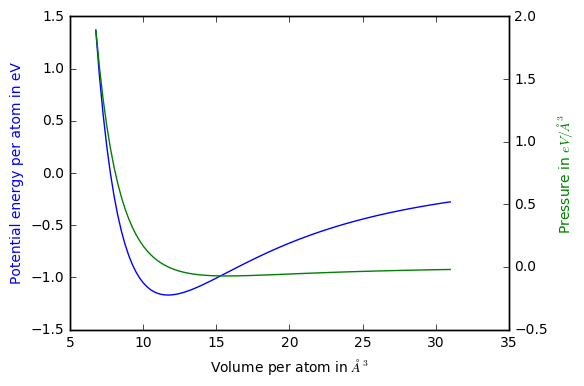

Bulk modulus using equation of state:         102.649858585 GPa
Bulk modulus from the pressures and volumes:  100.948566678 GPa


In [110]:
#Deliverable 1.2
from ase.eos import EquationOfState
from ase.units import kJ

pressures = []
cu = bulk("Cu", "fcc", a=3.6, cubic=True)
cu.set_calculator(calc)
vols = np.arange(start = 27.0, stop = 125.0, step = 1)
sides = vols**(1.0/3.0)
vols = np.divide(vols, 4)
pots = []
cell = cu.get_cell()
vol_eq = cell
for side in sides:
    cell = np.array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])
    cell *= side
    cu.set_cell(cell, scale_atoms=True)
    pressures.append(-np.trace(cu.get_stress(voigt=False))/3) #The strains should be the same along the diagonal, we can pick any
    pots.append(cu.get_potential_energy()/cu.get_number_of_atoms())
    
bulk_eq = 0.0
for index in range(len(sides)-1):
    if pots[index] == np.min(pots):
        dP = pressures[index+1] - pressures[index-1]
        dV = vols[index+1] - vols[index-1]
        bulk_eq = -vols[index]*dP/dV
    
    
    
#Plot the energies and pressures
fig, energies_plot = plt.subplots()
energies_plot.set_xlabel('Volume per atom in $Å^3$')
energies_plot.set_ylabel('Potential energy per atom in eV', color='b')
energies_plot.plot(vols, pots, 'b')
pressures_plot = energies_plot.twinx()
pressures_plot.set_ylabel('Pressure in $eV/Å^3$', color='g')
pressures_plot.plot(vols, pressures, 'g')
fig.tight_layout()
plt.show()

cell = np.array([[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 1.]])
cell *= 3.5
vol = 3.5**3.0
eos = EquationOfState(vols, pots, eos="birchmurnaghan")
v0, e0, B = eos.fit()
print('Bulk modulus using equation of state:        ', B / kJ * 1.0e24, 'GPa')
bulk_eq = bulk_eq / kJ * 1.0e24
print('Bulk modulus from the pressures and volumes: ', bulk_eq, 'GPa')

In [121]:
#Task and Deliverable 1.3
cu = bulk("Cu", "fcc", a=3.602878775, cubic=True)
cu.set_calculator(calc)
cell = cu.get_cell()
shears = np.arange(start=-0.04, stop=0.04, step = 0.001)
strains = np.divide(shears, cell[0,0])
A = (cell[0,0]**2)
shear_forces = []
for shear in shears:
    cell[1, 0] = shear
    cu.set_cell(cell)
    shear_forces.append(cu.get_stress(voigt=False))

shear_forces = np.array(shear_forces)
shear_stresses = shear_forces[:,1,0]/A #eV/Å^3
#print(np.array(shear_forces))
a, b = np.polyfit(np.array(strains), shear_stresses, deg=1) #a is basically the shear modulus
reg_line = strains * a + b
#plt.plot(strains, shear_stresses, 'red')
#plt.plot(strains, reg_line, 'blue')
#print(a, ' ', b)
#plt.show()
shear_modulus = a / kJ * 1.0e24
print('Shear modulus: ', shear_modulus, ' GPa')
#The shear modulus is off, I don't know why

Shear modulus:  6.5895759217  GPa


In [131]:
#Task and Deliverable 1.3 2nd part

a0 = 3.602878775
treshold = 1.e-9
cu = bulk("Cu", "fcc", a=a0, cubic=True)
cu.set_calculator(calc)
cell = cu.get_cell()
xStrain = 0.1
yzStrain_top = 0.
yzStrain_bottom = -xStrain
yzStrain = yzStrain_bottom
cell[0, 0] = (1 + xStrain)*a0
cu.set_cell(cell)
stress_top = cu.get_stress(voigt=False)[1,1]

cell[1, 1] = (1+yzStrain)*a0
cell[2, 2] = (1+yzStrain)*a0
cu.set_cell(cell)
stress = cu.get_stress(voigt=False)[1,1]
stress_bottom = stress

while abs(stress) > treshold:
    yzStrain = (yzStrain_top + yzStrain_bottom)/2.0
    cell[1, 1] = (1+yzStrain)*a0
    cell[2, 2] = (1+yzStrain)*a0
    cu.set_cell(cell)
    stress = cu.get_stress(voigt=False)[1,1]

    if stress*stress_top > 0:
        stress_top = stress
        yzStrain_top = yzStrain
    else:
        stress_bottom = stress
        yzStrain_bottom = yzStrain
        
#print(stress, ' ', yzStrain)
print('Poisson ratio of copper: ', -yzStrain/xStrain)

Poisson ratio of copper:  0.15537102520465848
